In [6]:
#libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb   #machine learning model based on random forest algorithm
from sklearn.metrics import mean_squared_error
#from sklearn.datasets import load_boston    #has tbeen removed
from sklearn.model_selection import train_test_split

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError,MeanSquaredPercentageError 

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Import data in .csv format and change Format of Datetime

In [7]:
df = pd.read_csv('Datasets/prc_Food_Germany_sorted.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

### First Training without Ukraine Confilct

In [8]:
df_cleaned = df.loc[df.index < '2021-11']

In [9]:
df_cleaned.head()

,FoodPriceIndex
Datetime,
1996-01-01,74.9
1996-02-01,75.5
1996-03-01,76.1
1996-04-01,76.4
1996-05-01,76.2


### Plot Data

<function matplotlib.pyplot.show(close=None, block=None)>

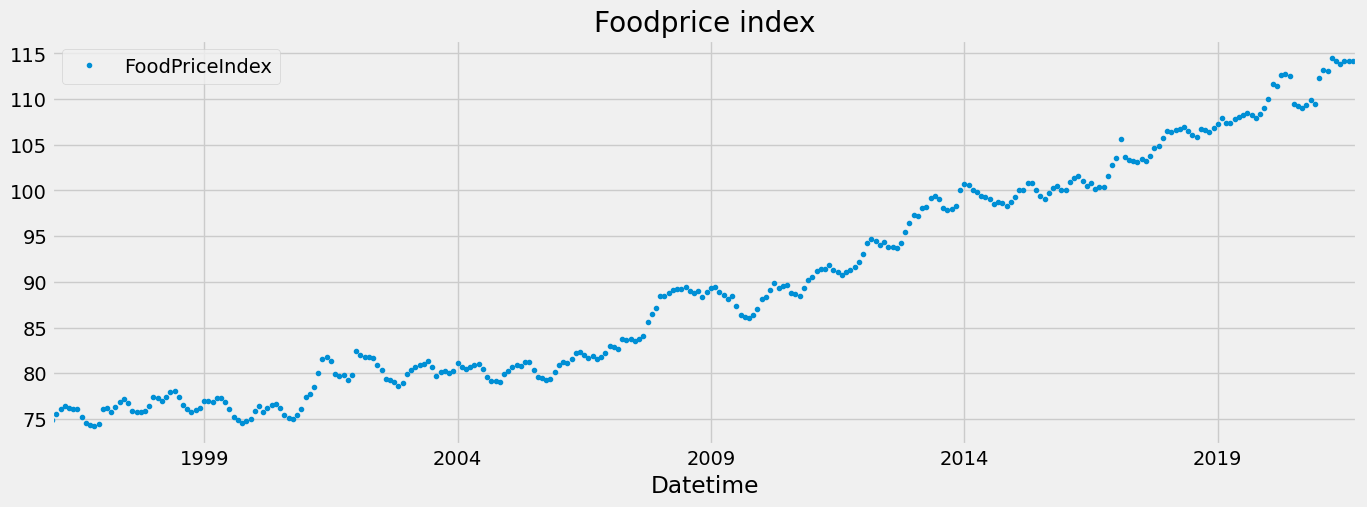

In [10]:
df_cleaned.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Foodprice index')
plt.show

## Train/Test Split

In [11]:
df_cleaned_diff = df_cleaned.diff()
df_cleaned_diff = df_cleaned_diff.dropna()

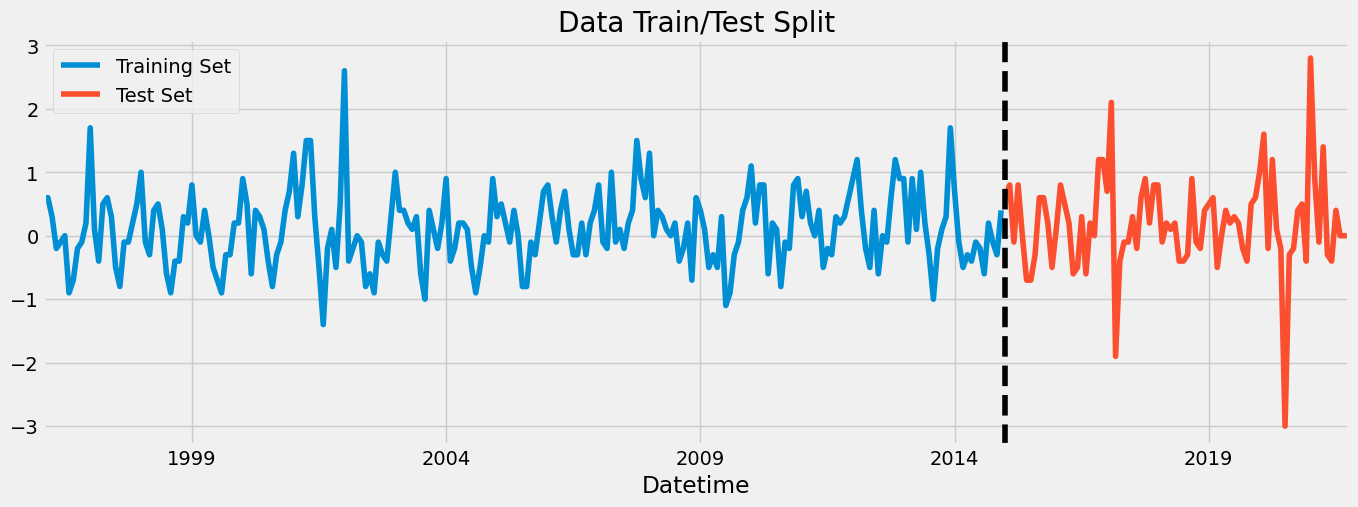

In [12]:
train = df_cleaned_diff.loc[df_cleaned_diff.index < '2015-01']
test = df_cleaned_diff.loc[df_cleaned_diff.index >= '2015-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2015-01',color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()
           

### Feature Creation

In [13]:
def create_features(df_cleaned_diff):
    """
    Create time series features based on time series index.

    """
    df_cleaned_diff = df_cleaned_diff.copy()
    df_cleaned_diff['Month'] = df_cleaned_diff.index.month
    df_cleaned_diff['Year'] = df_cleaned_diff.index.year
    df_cleaned_diff['Quarter'] = df_cleaned_diff.index.quarter
    #df_cleaned['MonthOfYear'] = df_cleaned.index.     gibts scheinbar nicht
    return df_cleaned_diff

df_cleaned_diff = create_features(df_cleaned_diff)

### Make the data stationary by differentiating

### Create our model

In [14]:
train = create_features(train)
train

,FoodPriceIndex,Month,Year,Quarter
Datetime,,,,
1996-02-01,0.6,2,1996,1
1996-03-01,0.6,3,1996,1
1996-04-01,0.3,4,1996,2
1996-05-01,-0.2,5,1996,2
1996-06-01,-0.1,6,1996,2
...,...,...,...,...
2014-08-01,-0.6,8,2014,3
2014-09-01,0.2,9,2014,3
2014-10-01,-0.1,10,2014,4


In [15]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Month','Year','Quarter']
TARGET = 'FoodPriceIndex'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
y_train

Datetime
1996-02-01    0.6
1996-03-01    0.6
1996-04-01    0.3
1996-05-01   -0.2
1996-06-01   -0.1
             ... 
2014-08-01   -0.6
2014-09-01    0.2
2014-10-01   -0.1
2014-11-01   -0.3
2014-12-01    0.4
Name: FoodPriceIndex, Length: 227, dtype: float64

### actually do the training

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',                        #xgb basiert auf random forest, dauert ca. 23 sekunden ohne gpu, easy schnmeasy
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,                                                       #wenn validation rmse wieder wächst hat man wohl overfitting
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

[23:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.69787	validation_1-rmse:0.81150
[20]	validation_0-rmse:0.62768	validation_1-rmse:0.77375
[40]	validation_0-rmse:0.57313	validation_1-rmse:0.74761
[60]	validation_0-rmse:0.52929	validation_1-rmse:0.72994
[80]	validation_0-rmse:0.49607	validation_1-rmse:0.71861
[100]	validation_0-rmse:0.46882	validation_1-rmse:0.70932
[120]	validation_0-rmse:0.44804	validation_1-rmse:0.70348
[140]	validation_0-rmse:0.43263	validation_1-rmse:0.70046
[160]	validation_0-rmse:0.42063	validation_1-rmse:0.69832
[180]	validation_0-rmse:0.41168	validation_1-rmse:0.69751
[200]	validation_0-rmse:0.40424	validation_1-rmse:0.69860
[220]	validation_0-rmse:0.39779	validation_1-rmse:0.70191
[223]	validation_0-rmse:0.39690	validation_1-rmse:0.70276


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

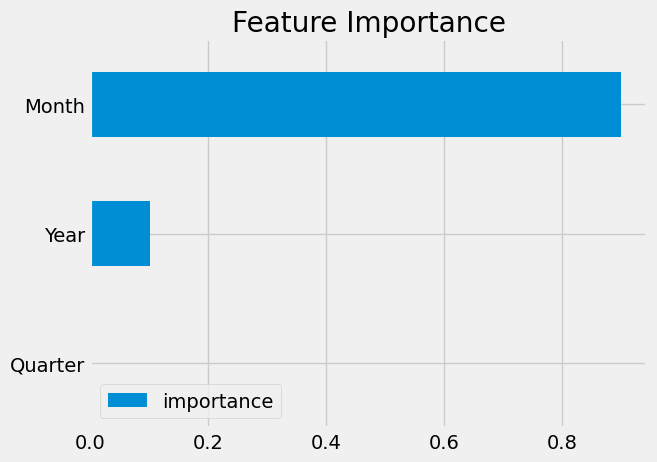

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### merge data

In [19]:
#dieser Block kompiliert irgendwie nur beim ersten mal. also einmal allen output löschen, 
#und dann nochmal alles ausführen ==> ja ist auch klar, das wird gemerget (der Dataframe wird geändert)
test['prediction'] = reg.predict(X_test)
df_cleaned_diff = df_cleaned_diff.merge(test[['prediction']], how='left', left_index=True, right_index=True)


### plot the results

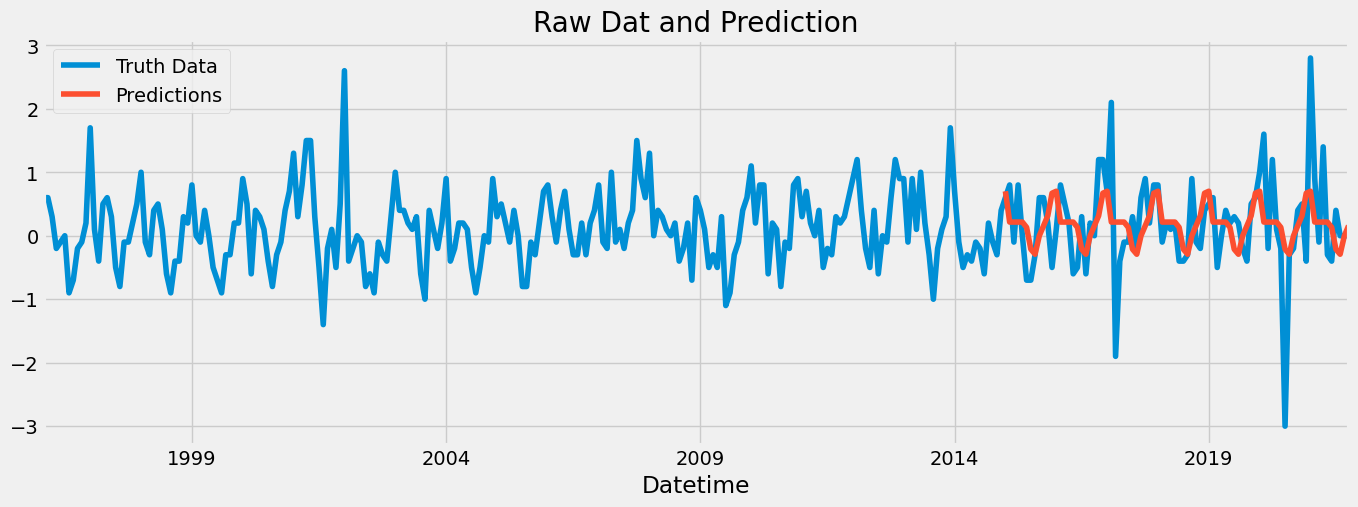

In [20]:
ax = df_cleaned_diff[['FoodPriceIndex']].plot(figsize=(15, 5))
df_cleaned_diff['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [21]:
df_cleaned_diff['prediction']

Datetime
1996-02-01         NaN
1996-03-01         NaN
1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
                ...   
2021-06-01    0.131782
2021-07-01   -0.212067
2021-08-01   -0.291363
2021-09-01   -0.000475
2021-10-01    0.158273
Name: prediction, Length: 309, dtype: float32

In [22]:
df_pred_absolute = df_cleaned_diff['prediction'].cumsum()


df_train_split = df_cleaned.loc[df_cleaned.index < '2015-01']
last_value = df_train_split.iloc[-1,0]

In [23]:
df_pred_absolute = df_pred_absolute.add(last_value)

In [24]:
df_cleaned_merged = df_cleaned.merge(df_pred_absolute, how='left', left_index=True, right_index=True)


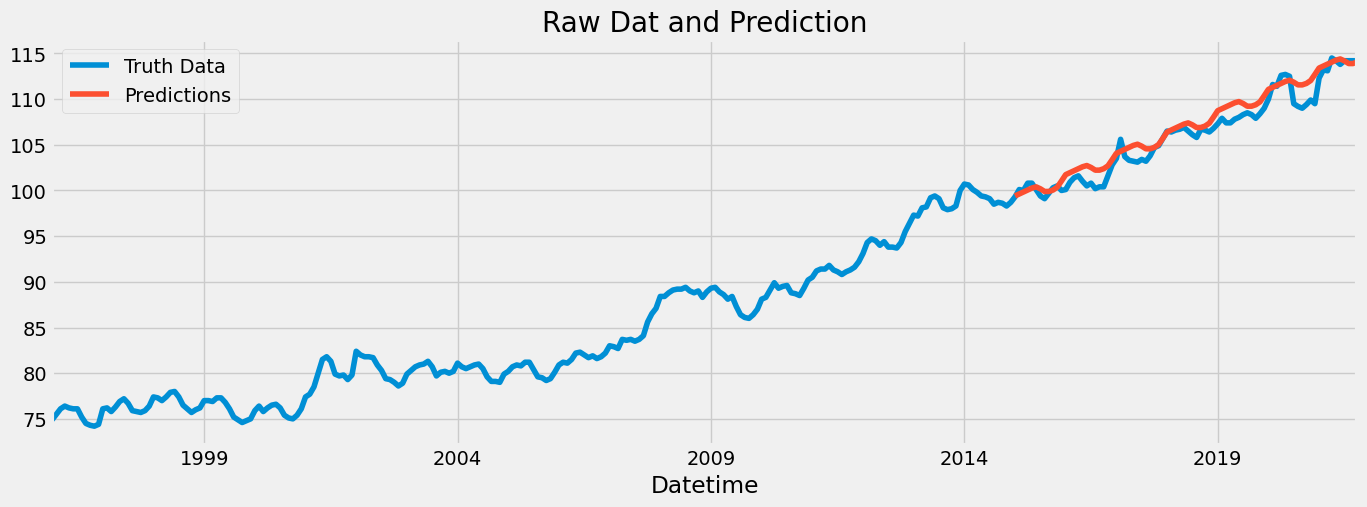

In [25]:
ax = df_cleaned_merged[['FoodPriceIndex']].plot(figsize=(15, 5))
df_cleaned_merged['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [26]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape.get_tag("lower_is_better")
mspe = MeanSquaredPercentageError(symmetric=False)
mspe.get_tag("lower_is_better")

True

In [27]:
df_test_split = df_cleaned.loc[df_cleaned.index >= '2015-01']
df_pred_absolute_split = df_pred_absolute.loc[df_pred_absolute.index >= '2015-01']

In [28]:
df_test_split

,FoodPriceIndex
Datetime,
2015-01-01,99.3
2015-02-01,100.1
2015-03-01,100.0
2015-04-01,100.8
2015-05-01,100.8
...,...
2021-06-01,113.8
2021-07-01,114.2
2021-08-01,114.2


In [34]:
df_pred_absolute_split

Datetime
2015-01-01   1970-01-01 00:00:00.000000099
2015-02-01   1970-01-01 00:00:00.000000099
2015-03-01   1970-01-01 00:00:00.000000099
2015-04-01   1970-01-01 00:00:00.000000100
2015-05-01   1970-01-01 00:00:00.000000100
                          ...             
2021-06-01   1970-01-01 00:00:00.000000114
2021-07-01   1970-01-01 00:00:00.000000114
2021-08-01   1970-01-01 00:00:00.000000113
2021-09-01   1970-01-01 00:00:00.000000113
2021-10-01   1970-01-01 00:00:00.000000114
Name: prediction, Length: 82, dtype: datetime64[ns]

In [29]:
mape(df_test_split,df_pred_absolute_split)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.009331482055076369

In [30]:
mspe(df_test_split,df_pred_absolute_split)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sktime\performance_metrics\forecasting\_classes.py:466: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


0.00013358926889714065